# Vertex AI: AutoML Image Classification - Model Tests (Edge + Cloud) & Explanations

Contributors: michaelmenzel@

This Colab facilitates test predictions with Cloud AutoML Vision generated models for image classification. The model can be queried on classifications of test images, either in the cloud or offline as exported model.

Moreover, this Colab provides explanations on the test predictions using the Saliency library.

Parameters needed are as minimal as possible, and you only need to provide:
- Project ID: project where the AutoML model was training.
- Model ID: the identifier of the trained model which can be found in the AutoML UI and API.
- Region: region the model was created in.
- Model Export Destination: a Cloud Storage URI to export the model to.
- Example Image: a Cloud Storage URI to an example image for test predictions and explanations.

In [ ]:
#@title Mandatory Libraries
!pip uninstall -q -y pandas-gbq > /dev/null 2>&1
!pip install -q google-cloud-aiplatform saliency > /dev/null 2>&1

print('Next the runtime is restarted. This cell may show an error. Please continue regardless.')
print('Killing runtime to activate libraries...')

import time
import os
time.sleep(1)
os.kill(os.getpid(), 9)

In [ ]:
#@title Parameters

import base64
import json
import os
import tempfile

import matplotlib.pyplot as plt

import tensorflow as tf
import saliency

from google.cloud import aiplatform as aiplatform, storage

project_id = 'sandbox-michael-menzel' #@param {type:"string"}
model_id = '2657044615311392768' #@param {type:"string"}
region = 'us-central1' #@param {type: "string"}
example_image = 'gs://automl-clouds-michael-menzel/cirrus/10.jpg' #@param {type:"string"}
model_export_destination = 'gs://automl-clouds-michael-menzel/models/' #@param {type:"string"}

service_account_name='automl-vision-icn-sa'

In [ ]:
#@title Authenticate

#@title Run this code to authenticate & obtain credentials [RUN]
!gcloud config set project $project_id
import googleapiclient.discovery
from google.oauth2 import service_account

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


In [ ]:
#@title Clients & Helpers
client_options = {"api_endpoint": f"{region}-aiplatform.googleapis.com"}

aipm_client = aiplatform.gapic.ModelServiceClient(client_options=client_options)
aipe_client = aiplatform.gapic.EndpointServiceClient(client_options=client_options)
aipp_client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
gcs_client = storage.Client(project=project_id)

model_full_id = aipm_client.model_path(project_id, region, model_id)
parent = f"projects/{project_id}/locations/{region}"

def get_image(gcs_uri):
  _, tf = tempfile.mkstemp()
  with open(tf, 'wb') as df:
    gcs_client.download_blob_to_file(example_image, df)

  with open(tf, 'rb') as df:
    return tf, df.read()

  return None, None

def plot_image(img_path):
  plt.imshow(plt.imread(tf.io.gfile.GFile(img_path, 'rb')))
  plt.axis('off')
  plt.show()

def plot_tensor(img_tensor, cmap=None):
  plt.imshow(img_tensor, cmap=cmap)
  plt.axis('off')
  plt.show()

def plot_tensor_overlay(img_tensor, overlay_tensor, alpha=0.5, cmap=None):
  plt.imshow(img_tensor)
  plt.imshow(overlay_tensor, alpha=alpha, cmap=cmap)
  plt.axis('off')
  plt.show() 

def model_details(model_full_id):
  request = aiplatform.gapic.GetModelRequest(name=model_full_id)
  model = aipm_client.get_model(request)
  print(f'Retrieved details of model {model_full_id}')
  return model

def deploy_model(model_full_id):
  model = model_details(model_full_id)
  existing_eps = list(aipe_client.list_endpoints(request={"parent": parent, "filter": "display_name=\"" + model.display_name + "_ep\""}))
  if len(existing_eps) > 0:
    ep_id = existing_eps[0].name
  else:
    ep_job = aipe_client.create_endpoint(parent=parent, endpoint={"display_name": model.display_name + "_ep"})
    ep_id = ep_job.result().name
    print(f'Created endpoint {ep_id}.')

    deploy_job = aipe_client.deploy_model(
        endpoint=ep_id, 
        traffic_split={'0': 100},
        deployed_model=aiplatform.gapic.DeployedModel(
            model=model_full_id,
            automatic_resources=aiplatform.gapic.AutomaticResources(min_replica_count=1, max_replica_count=1)))
    deploy_job.result()
    print(f'Deployed model {model_full_id} to endpoint {ep_id}.')

  return ep_id

def get_prediction(content, endpoint_id):
  return aipp_client.predict(endpoint=endpoint_id, instances=[{'content': content}])

def predict(gcs_uri, endpoint_id):
  return get_prediction(base64.b64encode(tf.io.read_file(example_image).numpy()).decode('utf-8'), endpoint_id)

def export_model(model_full_id, format='tf-saved-model'):
  output_config = aiplatform.gapic.ExportModelRequest.OutputConfig(
      artifact_destination=aiplatform.gapic.GcsDestination(output_uri_prefix=os.path.join(model_export_destination, model_id)),
      export_format_id=format
    )

  export_request = aiplatform.gapic.ExportModelRequest(name=model_full_id, output_config=output_config)
  export_job = aipm_client.export_model(request=export_request)
  export_job.result()

  gcs_source = export_job.metadata.output_info.artifact_output_uri
  local_dest = tempfile.mkdtemp()
  !gsutil -m cp -r $gcs_source/** $local_dest
  print('Stored exported model to folder:', local_dest)
  return gcs_source, local_dest

def load_model(model_file):
  tf_model = tf.saved_model.load(model_file, tags=['serve']).signatures['serving_default']
  print('Input Signature:', tf_model.structured_input_signature)
  print('Output Signature:', tf_model.structured_outputs)

  return tf_model

## Deploy Model

In [ ]:
endpoint_id = deploy_model(model_full_id)

Retrieved details of model projects/sandbox-michael-menzel/locations/us-central1/models/2657044615311392768


## Test Prediction

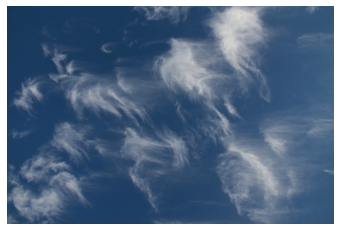

Class: cirrus with confidence: 0.933313847


In [ ]:
result = predict(example_image, endpoint_id)

labels = result.predictions[0]['displayNames']
max_score = max(result.predictions[0]['confidences'])
max_score_arg = tf.argmax(result.predictions[0]['confidences']).numpy()
max_label = labels[max_score_arg]

plot_image(example_image)
print(f"Class: {max_label} with confidence: {max_score}")

## Model Export

In [ ]:
gcs_export_model_location, model_file = export_model(model_full_id)
local_model = load_model(model_file)

Copying gs://automl-clouds-michael-menzel/models/2657044615311392768/model-2657044615311392768/tf-saved-model/2021-09-29T13:14:10.058709Z/saved_model.pb...
- [1/1 files][ 22.6 MiB/ 22.6 MiB] 100% Done                                    
Operation completed over 1 objects/22.6 MiB.                                     
Stored exported model to folder: /tmp/tmpez1zdy4v
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Input Signature: ((), {'image_bytes': TensorSpec(shape=(None,), dtype=tf.string, name='image_bytes'), 'key': TensorSpec(shape=(None,), dtype=tf.string, name='key')})
Output Signature: {'scores': <tf.Tensor 'scores:0' shape=(None, 3) dtype=float32>, 'key': <tf.Tensor 'Identity:0' shape=(None,) dtype=string>, 'labels': <tf.Tensor 'Tile:0' shape=(None, 3) dtype=string>}


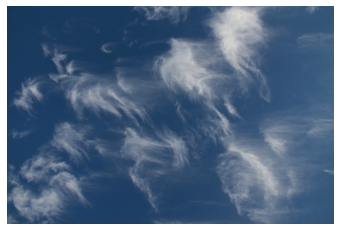

Class: cirrus with confidence: 0.9360285401344299


In [ ]:
local_annotation = local_model(key=tf.constant(['test']), image_bytes=tf.expand_dims(tf.io.read_file(example_image), -1))
max_score = tf.reduce_max(local_annotation['scores'], -1)[0]
max_score_arg = tf.argmax(tf.squeeze(local_annotation['scores'])).numpy()
max_label = str(tf.squeeze(local_annotation['labels'])[max_score_arg].numpy(), encoding='utf-8')

plot_image(example_image)
print(f"Class: {max_label} with confidence: {max_score}")

## Saliency (in TF 1)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:The specified SavedModel has no variables; no checkpoints were restored.
INFO:tensorflow:The specified SavedModel has no variables; no checkpoints were restored.


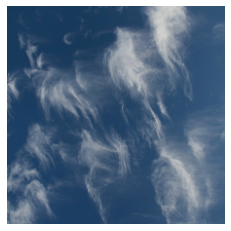

Class: b'cirrus' with confidence: 0.9360285401344299
INFO:saliency.core.xrai:Computing IG...
INFO:saliency.core.xrai:Done with IG. Computing XRAI...


In [ ]:
graph = tf.Graph()
with graph.as_default():
  sess = tf.compat.v1.Session(graph=graph)

  with sess.as_default():
    local_model = tf.compat.v1.saved_model.loader.load(sess, ["serve"], model_file)

    x           = graph.get_tensor_by_name("map/TensorArrayStack/TensorArrayGatherV3:0") #digging into the model's image preprocessing results
    img_inp_var = graph.get_tensor_by_name('Placeholder:0')
    image       = tf.io.read_file(example_image).eval()
    
    neuron_selector = tf.compat.v1.placeholder(tf.int32)
    logitDesc       = graph.get_tensor_by_name('Tile:0')
    logits          = graph.get_tensor_by_name('scores:0')
    prediction      = tf.argmax(logits, 1)
    y               = logits[0][neuron_selector]

    result = sess.run([prediction, logitDesc, logits, x] , feed_dict={img_inp_var: [image]} )

    prediction_class = result[0][0]
    prediction_class_name = result[1][0][prediction_class]
    max_score = result[2][0][prediction_class]
    img_raw = result[3][0]
    img_base = (img_raw + 1) / 2

    plot_tensor(img_base)
    print(f"Class: {prediction_class_name} with confidence: {max_score}")
    
    gradient_saliency = saliency.tf1.GradientSaliency(graph, sess, y, x)
    gs_smoothed_mask = saliency.tf1.VisualizeImageGrayscale(gradient_saliency.GetSmoothedMask(img_raw, feed_dict = {neuron_selector: prediction_class}))

    integrated_gradients = saliency.tf1.IntegratedGradients(graph, sess, y, x)
    ig_smoothed_mask = saliency.tf1.VisualizeImageGrayscale(gradient_saliency.GetSmoothedMask(img_raw, feed_dict = {neuron_selector: prediction_class}))

    xrai_saliency = saliency.tf1.XRAI(graph, sess, y, x)
    xrai_mask = xrai_saliency.GetMask(img_raw, feed_dict={neuron_selector: prediction_class})

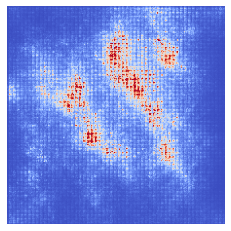

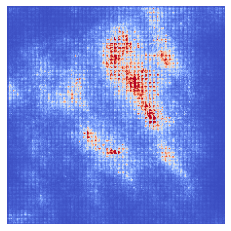

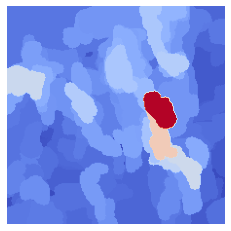

In [ ]:
plot_tensor(gs_smoothed_mask, cmap='coolwarm')
plot_tensor(ig_smoothed_mask, cmap='coolwarm')
plot_tensor(xrai_mask, cmap='coolwarm')

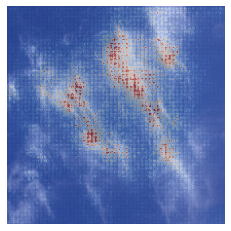

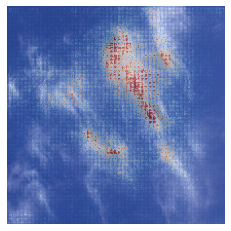

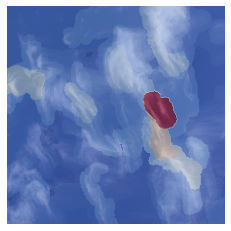

In [ ]:
plot_tensor_overlay(img_base, gs_smoothed_mask, cmap='coolwarm')
plot_tensor_overlay(img_base, ig_smoothed_mask, cmap='coolwarm')
plot_tensor_overlay(img_base, xrai_mask, cmap='coolwarm')